In [1]:
import psycopg2
import pandas as pd
import geopandas as gpd
import numpy as np
import json
from sqlalchemy import create_engine, text
from tqdm import tqdm
from geopy.distance import geodesic


# Define database connection parameters
database_connection = {
    'drivername': 'postgresql',
    'username': 'postgres',
    'password': 'postgres',
    'host': 'localhost',
    'port': '5432',
    'database': 'vic_db',
}


# A psycopg2 connection and cursor
conn = psycopg2.connect(user=database_connection['username'],
                        password=database_connection['password'],
                        host=database_connection['host'],
                        port=database_connection['port'],
                        database=database_connection['database'])
conn.autocommit = True
cursor = conn.cursor()

# Create a SQLAlchemy engine
engine = create_engine('postgresql://%(username)s:%(password)s@%(host)s/%(database)s' % database_connection, isolation_level="AUTOCOMMIT")
conn_alchemy = engine.connect()


In [146]:
# Implement A* algorithm to find the shortest path between two points

# def astar(start, goal):
#     frontier = []
#     visited = set()
#     path = []
#     frontier.append((0, start, []))
#     while frontier:
#         cost, current, path = frontier.pop(0)
#         if current == goal:
#             return path, cost
#         if current in visited:
#             continue
#         visited.add(current)
#         for neighbor_point, road_ufi, road_length in neighbors(current):
#             # frontier.append((cost + edge_cost(current, neighbor), neighbor, path + [neighbor]))
#             if neighbor_point not in visited:
#                 frontier.append((cost + road_length, neighbor_point, path + [road_ufi]))
#         frontier.sort(key=lambda x: x[0] + heuristic(x[1], goal))

# def neighbors(current):
#     sql = f"""
#     SELECT to_ufi, ufi, road_length_meters
#     FROM vmtrans.tr_road_all
#     WHERE from_ufi = {current}
#     AND (direction_code = 'B' OR direction_code = 'F')
#     """
#     cursor.execute(sql)
#     neighbors1 = cursor.fetchall()
#     sql = f"""
#     SELECT from_ufi, ufi, road_length_meters
#     FROM vmtrans.tr_road_all
#     WHERE to_ufi = {current}
#     AND (direction_code = 'B' OR direction_code = 'R')
#     """
#     cursor.execute(sql)
#     neighbors2 = cursor.fetchall()
#     return [(neighbor[0], neighbor[1], neighbor[2]) for neighbor in neighbors1 + neighbors2]


# def heuristic(current, goal):
#     sql = f"""
#     SELECT ST_Distance(
#         (SELECT geom FROM vmtrans.tr_points
#         WHERE ufi = {current}),
#         (SELECT geom FROM vmtrans.tr_points
#         WHERE ufi = {goal})
#     );
#     """
#     cursor.execute(sql)
#     return cursor.fetchall()[0][0]



In [2]:
points_coords = pd.read_sql_query(text("SELECT ufi, ST_X(geom::geometry) AS x, ST_Y(geom::geometry) AS y FROM vmtrans.tr_points;"), conn_alchemy)
points_coords.set_index('ufi', inplace=True)
points_coords = points_coords.to_dict(orient='index')
points_coords = {ufi: (coords['x'], coords['y']) for ufi, coords in points_coords.items()}
# 9s - 50s

In [3]:
# sql = "SELECT ufi, ezi_road_name_label, direction_code, from_ufi, to_ufi, road_length_meters, geom FROM vmtrans.tr_road_all;"
# roads_gdf = gpd.read_postgis(sql, con=engine)
roads_df = pd.read_sql_query(text("SELECT ufi, ezi_road_name_label, direction_code, from_ufi, to_ufi, road_length_meters FROM vmtrans.tr_road_all;"), conn_alchemy)
# 10s - 45s - 1m

In [6]:
# Convert roads into a list of tuples
roads = roads_df.to_dict(orient='records')

In [7]:
neighbors = {}
with tqdm(total=len(roads)) as pbar:
    for i, road in enumerate(roads):
        if road['direction_code'] == 'B' or road['direction_code'] == 'F':
            if road['from_ufi'] not in neighbors:
                neighbors[road['from_ufi']] = []
            neighbors[road['from_ufi']].append((road['to_ufi'], road['ufi'], road['road_length_meters']))
        if road['direction_code'] == 'B' or road['direction_code'] == 'R':
            if road['to_ufi'] not in neighbors:
                neighbors[road['to_ufi']] = []
            neighbors[road['to_ufi']].append((road['from_ufi'], road['ufi'], road['road_length_meters']))
        pbar.update(1)

100%|██████████| 1222415/1222415 [00:04<00:00, 247365.23it/s]


In [8]:


def heuristic(current, goal):
    # Get distance in real world from coordinates
    # Convert to meters
    # Calculate geodesic distance between two points in meters
    lon1, lat1 = points_coords[current]
    lon2, lat2 = points_coords[goal]
    distance = geodesic((lat1, lon1), (lat2, lon2)).meters
    return distance

def astar(start, goal):
    frontier = []
    visited = set()
    path = []
    frontier.append((0, 0, start, []))
    while frontier:
        _, cost, current, path = frontier.pop(0)
        # print(cost, current)
        if current == goal:
            return path, cost
        if current in visited:
            continue
        visited.add(current)
        for neighbor_point, road_ufi, road_length in neighbors.get(current, []):
            # frontier.append((cost + edge_cost(current, neighbor), neighbor, path + [neighbor]))
            if neighbor_point not in visited:
                heuristic_cost = heuristic(neighbor_point, goal)
                frontier.append((cost + road_length + heuristic_cost, cost + road_length, neighbor_point, path + [road_ufi]))
        frontier.sort(key=lambda x: x[0])

In [9]:
# Pick a random start and goal
distance = 0
while distance <= 400000:
    start = np.random.choice(list(points_coords.keys()))
    goal = np.random.choice(list(points_coords.keys()))
    distance = heuristic(start, goal)
start, goal, heuristic(start, goal), points_coords[start], points_coords[goal]

(60405446.0,
 49733686.0,
 411599.64290539187,
 (142.0695112830001, -33.03118002299993),
 (145.44998773100008, -35.45826235699997))

In [10]:
path, cost = astar(start, goal)
# 3m

In [55]:
sql = f"""
SELECT ufi, ezi_road_name_label, direction_code, road_length_meters, geom
FROM vmtrans.tr_road_all
WHERE ufi IN ({','.join([str(int(ufi)) for ufi in path])});
"""
gdf = gpd.read_postgis(sql, con=engine)
gdf['geometry'] = gdf['geom'].apply(lambda x: x.geoms[0])
gdf.drop(columns=['geom'], inplace=True)
gdf = gpd.GeoDataFrame(gdf, crs='EPSG:7844', geometry='geometry')

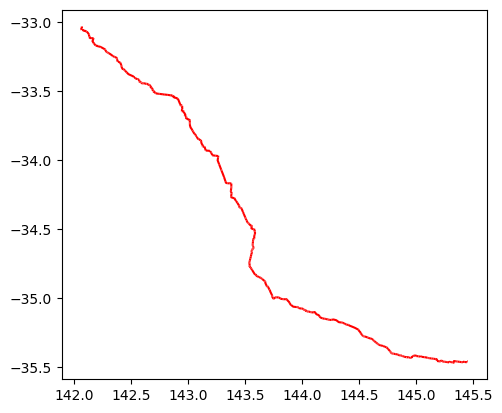

In [60]:
# Plot the path
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
gdf.plot(ax=ax, color='red')
plt.show()

In [75]:
def get_neighbors(current):
    sql = f"""
    SELECT to_ufi, ufi, road_length_meters
    FROM vmtrans.tr_road_all
    WHERE from_ufi = {current}
    AND (direction_code = 'B' OR direction_code = 'F')
    """
    cursor.execute(sql)
    neighbors1 = cursor.fetchall()
    sql = f"""
    SELECT from_ufi, ufi, road_length_meters
    FROM vmtrans.tr_road_all
    WHERE to_ufi = {current}
    AND (direction_code = 'B' OR direction_code = 'R')
    """
    cursor.execute(sql)
    neighbors2 = cursor.fetchall()
    return [(neighbor[0], neighbor[1], neighbor[2]) for neighbor in neighbors1 + neighbors2]


def get_heuristic(current, goal):
    sql = f"""
    SELECT ST_X(geom::geometry) AS x, ST_Y(geom::geometry) AS y FROM vmtrans.tr_points
    WHERE ufi = {int(current)} OR ufi = {int(goal)};
    """
    cursor.execute(sql)
    current_coords, goal_coords = cursor.fetchall()
    current_coords = (current_coords[1], current_coords[0])
    goal_coords = (goal_coords[1], goal_coords[0])
    distance = geodesic(current_coords, goal_coords).meters
    return distance



def astardb(start, goal):
    frontier = []
    visited = set()
    path = []
    frontier.append((0, 0, start, []))
    while frontier:
        hcost, cost, current, path = frontier.pop(0)
        print(len(path), len(frontier), hcost, cost, current)
        if current == goal:
            return path, cost
        if current in visited:
            continue
        visited.add(current)
        for neighbor_point, road_ufi, road_length in get_neighbors(current):
            # frontier.append((cost + edge_cost(current, neighbor), neighbor, path + [neighbor]))
            if neighbor_point not in visited:
                heuristic_cost = get_heuristic(neighbor_point, goal)
                frontier.append((cost + road_length + heuristic_cost, cost + road_length, neighbor_point, path + [road_ufi]))
        frontier.sort(key=lambda x: x[0])




In [69]:
start, goal, get_heuristic(start, goal), points_coords[start], points_coords[goal]

(60405446.0,
 49733686.0,
 411599.64290539187,
 (142.0695112830001, -33.03118002299993),
 (145.44998773100008, -35.45826235699997))

In [76]:
path2, cost2 = astardb(start, goal)

0 0 0 0 60405446.0
1 2 412874.6210382931 3480.639588940913 60405630.0
2 3 413263.7757047374 4320.893862334076 60405621.0
3 4 413598.7336723981 5037.385594693255 60405613.0
3 5 413608.17392790254 7757.100426616538 60405672.0
2 6 413643.20544887654 3972.397254779132 60405637.0
4 7 413667.0153995271 10699.07712839001 60405744.0
5 8 413833.6427684404 12586.42459120957 60405806.0
3 9 414029.60147979413 7292.193977840274 60405747.0
5 8 414051.76022722694 12657.07259660111 60405814.0
4 8 414157.4518126155 7479.153554892262 60405618.0
5 8 414162.9859133842 7502.943661811423 60405619.0
6 8 414189.64711056394 8152.51185537377 60405629.0
7 10 414279.29768849845 8720.81187693833 60405646.0
6 9 414346.42474639637 13792.100624676163 60405844.0
7 9 414380.09083159466 13954.63614975897 60405847.0
6 10 414553.9383874436 13159.250756817773 60405814.0
7 9 414710.3722983422 11199.685764210068 60405645.0
8 10 414712.83072195837 15527.494546441774 60405848.0
8 10 414713.32895204326 11350.80348843174 6040565

KeyboardInterrupt: 